In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve,generate_binary_structure

### Laplaces Equation:


$$\boxed{\nabla^2 V=0 \hspace{20mm} V_{\Omega_1}(\vec{r}) = \phi(x,y,z) \hspace{5mm} \frac{\partial V_{\Omega_2}}{\partial n} = 0}$$

* Blue region below represents $\Omega_1$. These are places of **fixed potential**, and represent **conductors**. 
* Grey region below represents $\Omega_2$. These represent regions of **fixed charge** (in this case, $0$) and represent **insulators**.

<p align="center">
  <img src="images/vid31p1.PNG" alt="drawing" width="300" align="center"/>
</p>

We are in 3D space, so this means

$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2} + \frac{\partial^2 V}{\partial z^2}=0$$

This equation can be discretely approximated as

$$\frac{V_{i+1,j,k} - 2V_{i,j,k} + V_{i-1,j,k}}{(\Delta x)^2} + \frac{V_{i,j+1,k} - 2V_{i,j,k} + V_{i,j-1,k}}{(\Delta y)^2}+ \frac{V_{i,j,k+1} - 2V_{i,j,k} + V_{i,j,k-1}}{(\Delta z)^2} = 0 $$

Noting that $ \Delta x = \Delta y =\Delta z$ in our array, we can solve for $V(x_i, y_j)$ yielding

$$\boxed{V_{i,j,k}= \frac{1}{6}\left(V_{i+1,j,k}+V_{i-1,j,k}+ V_{i,j+1,k}+ V_{i,j-1,k}+ V_{i,j,k+1}+ V_{i+1,j,k-1} \right)}$$

The expression above is a **property** of the **true** solution. We don't know the true solution. An idea, however, is to repeatedly set

$$V_{i,j,k} \to \frac{1}{6}\left(V_{i+1,j,k}+V_{i-1,j,k}+ V_{i,j+1,k}+ V_{i,j-1,k}+ V_{i,j,k+1}+ V_{i+1,j,k-1} \right)$$

and hope that $V$ will eventually converge to the true solution. It turns out that it can be mathematically proven that this is the case. In order to do this, we need a good initial guess for $V_{i,j,k}$.

The problem we will solve today is

<p align="center">
  <img src="images/vid31p2.PNG" alt="drawing" width="300" align="center"/>
</p>

This is a 2D picture, but we are solving it in 3 dimensions. It represents two parallel plates held at constant potential (**conductors**) surrounded by an **insulating** box with a constant charge of 0. The idea is that it gives the **true potential of finite area parallel plates** at all points in space. The conducting box provides a good approximation of the infinite boundary condition that $V \to 0$ as $\vec{r} \to \infty$.

In [2]:
# create 3D mesh 
N = 100
grid = np.zeros((N,N,N)) + 0.5

In [8]:
# create the constant potentials 
grid[30:70,30:70,20] = 1
grid[30:70,30:70,80] = 0 

mask_pos = grid == 1
mask_neg = grid == 0

In [9]:
yv,xv,zv = np.meshgrid(np.arange(N),np.arange(N),np.arange(N))

### Use of convolution 

Now, as we know, we need to apply

$$V_{i,j,k} \to \frac{1}{6}\left(V_{i+1,j,k}+V_{i-1,j,k}+ V_{i,j+1,k}+ V_{i,j-1,k}+ V_{i,j,k+1}+ V_{i+1,j,k-1} \right)$$

over and over and we will eventually get the true potential at all places in space. It turns out that this can be represented by a convolution. Think about the 2D analog $V_{i,j} \to \frac{1}{4}\left(V_{i+1,j}+V_{i-1,j}+ V_{i,j+1}+ V_{i,j-1} \right)$. Consider the example below.

<p align="center">
  <img src="/images/vid31p3.png" alt="drawing" width="300" align="center"/>
</p>

* The red box represents $V_{i,j}$. This value, initially equal to 5, will be updated in the next iteration
* The purple boxes represent $V_{i+1,j}, V_{i-1,j}, V_{i,j+1}, V_{i,j-1}$
* Thus in the next iteration $V_{i,j} \to \frac{1}{4}(1+2+6+7) = 4$

This occurs for all pixels in the array. It follows that this operation is equal to a convolution with the matrix

$$\begin{bmatrix} 0 & 1/4 & 0\\ 1/4 & 0 & 1/4 \\ 0 & 1/4 & 0\\ \end{bmatrix}$$

In 3D, the analog is:

In [15]:
kern = generate_binary_structure(3,1).astype(float)/6
kern[1,1,1] =0
kern

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.16666667, 0.        ],
        [0.16666667, 0.        , 0.16666667],
        [0.        , 0.16666667, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]]])

In [17]:
# function to set the neuman condition 

def neuman(a):
    a[0,:,:] = a[1,:,:]; a[-1,:,:] = a[-2,:,:]
    a[:,0,:] = a[:,1,:]; a[:,-1,:] = a[:,-2,:]
    a[:,:,0] = a[:,:,1]; a[:,:,-1] = a[:,:,-2]
    return a 
    

In [18]:
# iteratively solve for potential 

convergence = []
iters = 2000
for i in range(iters):
    grid_updated = convolve(grid,kern,mode='constant')
    # apply neuman BC 
    grid_updated = neuman(grid_updated)
    # dirchlet BC
    grid_updated[mask_pos] = 1
    grid_updated[mask_neg] = 0 
    # update the convergence (between two consecetive iterations)
    convergence.append(np.mean((grid - grid_updated)**2))
    grid = grid_updated

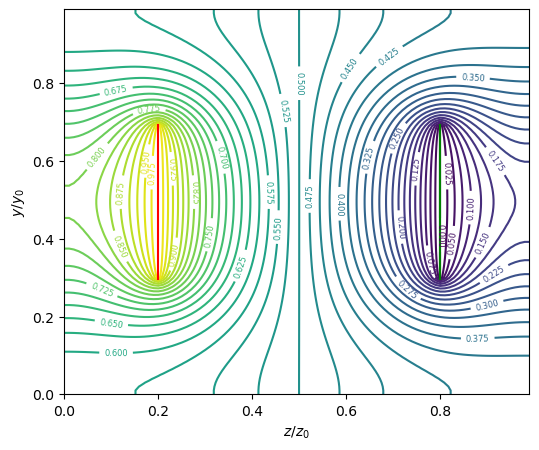

In [19]:
# plot 

slc = 40 
plt.figure(figsize=(6,5))
CS = plt.contour(np.arange(100)/100, np.arange(100)/100, grid[slc], levels=40)
plt.clabel(CS, CS.levels, inline=True, fontsize=6)
plt.xlabel('$z/z_0$')
plt.ylabel('$y/y_0$')
plt.axvline(0.2, ymin=0.3, ymax=0.7, color='r')
plt.axvline(0.8, ymin=0.3, ymax=0.7, color='g')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


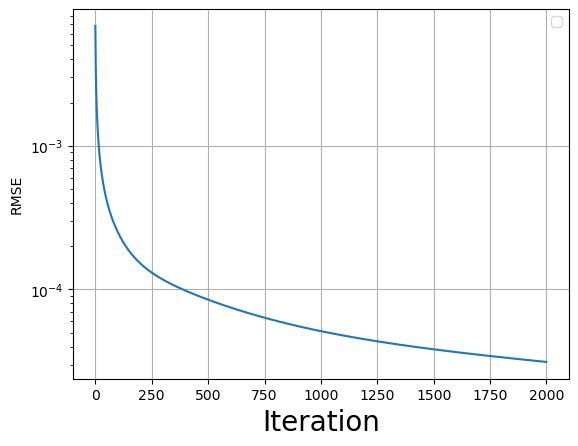

In [22]:
# convergence plot
plt.semilogy(np.sqrt(np.array(convergence)))
plt.legend()
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'RMSE')
plt.grid()